## Comparing Covid-19 cases with University population
This code loads data from various places regarding covid-19 cases and University information.  These data are defined
at the Middle Layer Super Output Are (MSOA) level

In [86]:

import pandas
import numpy as np
import requests
import os.path
import time
from uk_covid19 import Cov19API

In [87]:

# Calculate distances between lat/lon in miles.
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    dist = 3958 * dist  # 6367 for distance in KM for miles use 3958
    return dist

# simple wrapper to download datafiles from source.
def get_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url)
    open(local_filename, 'wb').write(r.content)
    return

In [88]:

#This file contains the population weighted centroid location of each MSOA
if not os.path.isfile('./MSOA_2011_EW_PWC_COORD_V2.CSV'):
    url = "https://github.com/ITSLeeds/pct/releases/download/0.2.5/MSOA_2011_EW_PWC_COORD_V2.CSV"
    get_file(url)

# The sit: http://learning-provider.data.ac.uk contains lots of information for univeristy
# This includes the main locaiton of the university.  But doesn't include all campuses.
if not os.path.isfile('./learning-providers-plus.csv'):
    url = "http://learning-provider.data.ac.uk/data/learning-providers-plus.csv"
    get_file(url)

# # Get the latest case data from gov.uk
filename = './MSOAs_latest.csv'
# # if the file doesn't exist or it is more than 24 hours old
if not os.path.isfile(filename) or \
        (time.time() - os.path.getmtime(filename)) / (60 * 60) > 24:
    url = "https://coronavirus.data.gov.uk/downloads/msoa_data/MSOAs_latest.csv"
    get_file(url)

In [89]:
# # Not implemeented fully.
# all_nations = [
#     "areaType=ltla"
#
# ]
#
# cases_and_deaths = {
#     "date": "date",
#     "areaName": "areaName",
#     "areaCode": "areaCode",
#     "newCasesByPublishDate": "newCasesByPublishDate",
#     # "newCasesBySpecimenDate": "newCasesBySpecimenDate",
#     # "cumCasesByPublishDate": "cumCasesByPublishDate",
#     # "newDeathsByDeathDate": "newDeathsByDeathDate",
#     # "cumDeathsByDeathDate": "cumDeathsByDeathDate"
#    # "newTestsByPublishDate": "newTestsByPublishDate"
# }
#
# api = Cov19API(
#     filters=all_nations,
#     structure=cases_and_deaths,
#     latest_by="newCasesByPublishDate"
# )
#
#  # api.get_csv(save_as="data.csv")
#  #  df = pandas.read_csv('./data.csv')
# df = api.get_dataframe()
# #data = api.get_json()

In [90]:
MSOA_centroids = pandas.read_csv('./MSOA_2011_EW_PWC_COORD_V2.CSV')

#The MSO population data comes from this table from the ONS:
#Table SAPE22DT4: Mid-2019 Population Estimates for Middle Layer Super Output Areas
#in England and Wales by Single Year of Age and Sex - Supporting Information
MSOA_pop = pandas.read_csv('./MSOA_pop.csv')
HE_centroids = pandas.read_csv('./learning-providers-plus.csv')
covidCases = pandas.read_csv('./MSOAs_latest.csv')
covidFileTimeStamp = os.path.getmtime('./MSOAs_latest.csv')

#Pop Density comes from Table QS102EW
#https://www.nomisweb.co.uk/census/2011/qs102uk
MSOA_density=pandas.read_csv('./MSOA_density.csv')
MSOA_density['msoacd']=MSOA_density['msoacd'].str.replace(' : (.*)','',regex=True)

#The student population numbers come from Table ID: DC6108EW, from the 2011 census
#https://www.nomisweb.co.uk/census/2011/dc6108ew
MSOA_student_pop = pandas.read_csv('./MSOA_student_pop.csv')

#Number of employees in bars/restuarants comes from the employee survey:
#https://www.nomisweb.co.uk/datasets/newbres6pub
MSOA_pubs = pandas.read_csv('./MSOA_pubs_bars.csv')
MSOA_pubs['msoacd']=MSOA_pubs['msoacd'].str.replace(' : (.*)','',regex=True)


#Definitions for several groupings of univeristies.
russell_group_rows = (HE_centroids['GROUPS'].str.contains('Russell_Group') == True)
million_plus_rows = (HE_centroids['GROUPS'].str.contains('Million') == True)
UA_rows = (HE_centroids['GROUPS'].str.contains('University_Alliance') == True)

# You can uncomment and/or change theses lines to pick a selection of unis
unis_2_keep = np.ones((len(HE_centroids.index))) > 0 # All Unis
# unis_2_keep = russell_group_rows | million_plus_rows
# unis_2_keep =  russell_group_rows
HE_centroids = HE_centroids.loc[unis_2_keep, :]

HE_lon = HE_centroids['LONGITUDE']
HE_lat = HE_centroids['LATITUDE']

# Calculate distances. NOTE: Using a for loop like this is a very slow way to do it
# but is generally more clear to read.
allDist = np.zeros((len(MSOA_centroids.index), len(HE_centroids.index)))

for index, row in MSOA_centroids.iterrows():
    this_MSOA_lon = row['LONGITUDE']
    this_MSOA_lat = row['LATITUDE']

    theseDist = haversine(this_MSOA_lon, this_MSOA_lat, HE_lon, HE_lat)
    allDist[index,] = theseDist

#Calculate the distance to nearest university.
uni_distance = np.nanmin(allDist, axis=1)
rg_distance = np.nanmin(allDist[:, russell_group_rows], axis=1)
mp_distance = np.nanmin(allDist[:, million_plus_rows], axis=1)
closestUniIdx = np.nanargmin(allDist, axis=1)
tmp = allDist
#Stupid way to remove non russell group from disance calc.  Just set the distance to highvalue
tmp[:, (-1*russell_group_rows.values+1)==1]=10000
closestRgIdx = np.nanargmin(tmp, axis=1)

uni_name = HE_centroids['PROVIDER_NAME'].iloc[closestUniIdx].values
rg_name  = HE_centroids['PROVIDER_NAME'].iloc[closestRgIdx].values
MSOA_centroids.insert(1, "uni_distance", uni_distance)
MSOA_centroids.insert(1, "rg_distance", rg_distance)
MSOA_centroids.insert(1, "mp_distance", mp_distance)
MSOA_centroids.insert(1, "uni_name", uni_name)
MSOA_centroids.insert(1, "rg_name", rg_name)



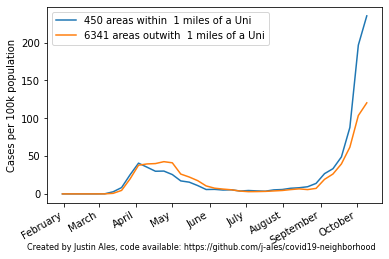

In [91]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

#***
# Distance in miles to use separate areas
distThresh = 1
#*****



merged = pandas.merge(left=MSOA_centroids, right=covidCases, left_on='MSOA11CD', right_on='msoa11_cd')
merged = pandas.merge(left=merged, right=MSOA_pop, left_on='MSOA11CD', right_on='MSOA Code')
merged = pandas.merge(left=merged, right=MSOA_student_pop, left_on='MSOA11CD', right_on='MSOA Code')
merged = pandas.merge(left=merged, right=MSOA_density, left_on='MSOA11CD', right_on='msoacd')
merged = pandas.merge(left=merged, right=MSOA_pubs, left_on='MSOA11CD', right_on='msoacd')


merged = merged.replace(-99, 0)
merged = merged.sort_values('uni_distance')

#Normalize by MSOA population
merged['latest_7_days_per_100k'] = 1e5 * merged.filter(like='latest_7_days').div(merged['Total Pop'], axis=0)
merged['Student Percentage'] = merged['Student Population'] / merged['Total Pop']

close = merged.loc[merged['uni_distance'] < distThresh, :]
far = merged.loc[merged['uni_distance'] >= distThresh, :]
numberClose = len(close)
numberFar = len(far)
# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['Total Pop'])
farTotalPop = np.sum(far['Total Pop'])
# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop

closeCasePer100 = np.nanmean(1e5 * close.filter(regex='wk_*|latest_7_days(?!_)').div(close['Total Pop'], axis=0), axis=0)
farCasePer100 = np.nanmean(1e5 * far.filter(regex='wk_*|latest_7_days(?!_)').div(far['Total Pop'], axis=0), axis=0)

first = datetime.datetime.fromisocalendar(2020, 5, 5)
last  = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)-1+5, 6)
date_range = mdates.drange(first,last,datetime.timedelta(days=7))


plt.plot(date_range,closeCasePer100)
plt.plot(date_range,farCasePer100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))
plt.ylabel('Cases per 100k population')
plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -40), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)
plt.gcf().autofmt_xdate()

plt.legend([str(numberClose) + ' areas within  ' + str(distThresh ) + ' miles of a Uni',
            str(numberFar) + ' areas outwith  ' + str(distThresh ) + ' miles of a Uni'])

plt.show()

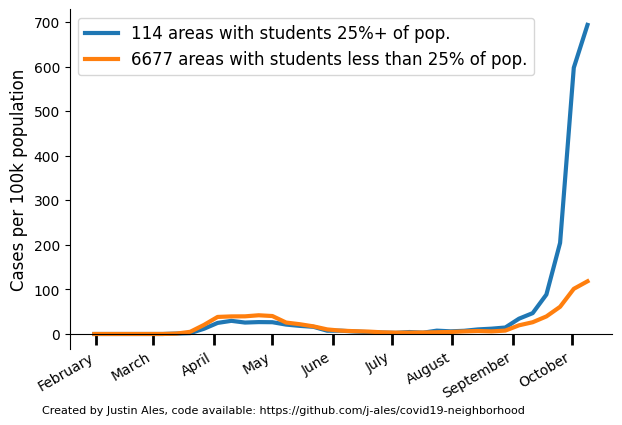

In [92]:

###

popThresh = .25
#distThresh = 500
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
uniGroup   = 'uni_distance'
#uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
selectTheseUni = np.full(merged.shape[0], True)
#selectTheseUni = (merged['uni_name']=='UNIVERSITY OF OXFORD') | (merged['uni_name']=='UNIVERSITY OF CAMBRIDGE')

close = merged.loc[( merged[classifyBy] >= popThresh) & selectTheseUni, :]
far = merged.loc[ (merged[classifyBy] < popThresh) & selectTheseUni, :]
rest = merged.loc[~selectTheseUni, :]



# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['Total Pop'])
farTotalPop = np.sum(far['Total Pop'])
restTotalPop = np.sum(rest['Total Pop'])

# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop
filterSpec='wk_*|latest_7_days(?!_)'
#filterSpec = 'wk_*'

closeCasePer100 = np.nanmean(1e5 * close.filter(regex=filterSpec).div(close['Total Pop'], axis=0), axis=0)
farCasePer100 = np.nanmean(1e5 * far.filter(regex=filterSpec).div(far['Total Pop'], axis=0), axis=0)
#restCasePer100 = np.nanmean(1e5 * rest.filter(regex=filterSpec).div(rest['Total Pop'], axis=0), axis=0)

# closeCasePer100 = np.nansum(close.filter(regex='wk_*'), axis=0)
# farCasePer100 = np.nansum(far.filter(regex='wk_*'), axis=0)

numberClose = len(close)
numberFar = len(far)

first = datetime.datetime.fromisocalendar(2020, 5, 7)
last  = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5, 7)
date_range = mdates.drange(first,last,datetime.timedelta(days=7))

fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(1, 1, 1)


ax.plot(date_range,closeCasePer100, linewidth=3)
ax.plot(date_range,farCasePer100, linewidth=3)
#ax.plot(date_range,restCasePer100, linewidth=3)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_position('zero')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=2,length=8)
plt.ylabel('Cases per 100k population',fontsize=12)
#plt.yscale("log")
#plt.ylim(1,10e3)
plt.xlim([datetime.date(2020, 7, 1), date_range[-1]+4])

shadeFrom = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5-1, 1)
shadeTo   = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5-1+1, 2)

ax.fill_between( (shadeFrom,shadeTo),ax.get_ylim()[0],ax.get_ylim()[1], alpha=0.25)

# "You scored {:.0%}"
# '{} areas where students are {:.0%} of pop.'.format(numberClose,thresh)
plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberClose,popThresh),
            '{} areas with students less than {:.0%} of pop.'.format(numberFar,popThresh)],
           fontsize=12)



# plt.title('Cases Per 100k in Univ')
plt.gcf().autofmt_xdate()
plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -50), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)
plt.annotate('Latest Week Provisional\nsubject to revision.',
             (.8,.1), (0, 0), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)

plt.show()

In [ ]:

###

popThresh = .25
distThresh = 2
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
#uniGroup   = 'uni_distance'
uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
selectTheseUni = np.full(merged.shape[0], True)
#selectTheseUni = (merged['uni_name']=='UNIVERSITY OF OXFORD') | (merged['uni_name']=='UNIVERSITY OF CAMBRIDGE')

close = merged.loc[( merged[classifyBy] >= popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni , :]
far = merged.loc[ (merged[classifyBy] < popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni, :]
rest = merged.loc[(merged[uniGroup] >= distThresh), :]



# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['Total Pop'])
farTotalPop = np.sum(far['Total Pop'])
restTotalPop = np.sum(rest['Total Pop'])

# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop
filterSpec='wk_*|latest_7_days(?!_)'
#filterSpec = 'wk_*'

closeCasePer100 = np.nanmean(1e5 * close.filter(regex=filterSpec).div(close['Total Pop'], axis=0), axis=0)
farCasePer100 = np.nanmean(1e5 * far.filter(regex=filterSpec).div(far['Total Pop'], axis=0), axis=0)
restCasePer100 = np.nanmean(1e5 * rest.filter(regex=filterSpec).div(rest['Total Pop'], axis=0), axis=0)

# closeCasePer100 = np.nansum(close.filter(regex='wk_*'), axis=0)
# farCasePer100 = np.nansum(far.filter(regex='wk_*'), axis=0)

numberClose = len(close)
numberFar = len(far)

first = datetime.datetime.fromisocalendar(2020, 5, 7)
last  = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5, 7)
date_range = mdates.drange(first,last,datetime.timedelta(days=7))

fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(1, 1, 1)


ax.plot(date_range,closeCasePer100, linewidth=3)
ax.plot(date_range,farCasePer100, linewidth=3)
ax.plot(date_range,restCasePer100, linewidth=3)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_position('zero')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=2,length=8)
plt.ylabel('Cases per 100k population',fontsize=12)
#plt.yscale("log")
#plt.ylim(1,10e3)
plt.xlim([datetime.date(2020, 7, 1), date_range[-1]+4])

shadeFrom = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5-1, 1)
shadeTo   = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5-1+1, 2)

ax.fill_between( (shadeFrom,shadeTo),ax.get_ylim()[0],ax.get_ylim()[1], alpha=0.15)

# "You scored {:.0%}"
# '{} areas where students are {:.0%} of pop.'.format(numberClose,thresh)
# plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberClose,popThresh),
#             '{} areas with students less than {:.0%} of pop.'.format(numberFar,popThresh)],
#            fontsize=12)

# plt.legend(['{} areas within {} mile of Oxbridge\n and students over {:.0%} of population'.format(numberClose,distThreshNear, popThresh),
#             '{} areas within {} mile of Oxbridge\n and students below {:.0%} of population'.format(numberFar,distThreshNear, popThresh),
#             '{} areas outside of Oxbridge'.format(len(rest))],
#             fontsize=12)

plt.legend(['{} areas within {} miles of Russell Group university\n and students over {:.0%} of population'.format(numberClose,distThresh, popThresh),
             '{} areas within {} miles of Russell Group university\n and students below {:.0%} of population'.format(numberFar,distThresh, popThresh),
            '{} areas outside {} miles of a Russell Group university'.format(len(rest),distThresh)],
            fontsize=12)

# plt.title('Cases Per 100k in Univ')
plt.gcf().autofmt_xdate()
plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -50), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)
plt.annotate('Latest Week Provisional\nsubject to revision.',
             (.8,.1), (0, 0), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)

plt.show()

In [ ]:

###

popThresh = .25
distThresh = 5
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
#Choose russell group set, or all universities.
#uniGroup   = 'uni_distance'
uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
#selectTheseUni = np.full(merged.shape[0], True)
selectTheseUni = (merged['uni_name']=='UNIVERSITY OF OXFORD') | (merged['uni_name']=='UNIVERSITY OF CAMBRIDGE')

close = merged.loc[( merged[classifyBy] >= popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni , :]
far = merged.loc[ (merged[classifyBy] < popThresh) & (merged[uniGroup] < distThresh) & selectTheseUni, :]
rest = merged.loc[~selectTheseUni, :]



# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['Total Pop'])
farTotalPop = np.sum(far['Total Pop'])
restTotalPop = np.sum(rest['Total Pop'])

# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop
filterSpec='wk_*|latest_7_days(?!_)'
#filterSpec = 'wk_*'

closeCasePer100 = np.nanmean(1e5 * close.filter(regex=filterSpec).div(close['Total Pop'], axis=0), axis=0)
farCasePer100 = np.nanmean(1e5 * far.filter(regex=filterSpec).div(far['Total Pop'], axis=0), axis=0)
restCasePer100 = np.nanmean(1e5 * rest.filter(regex=filterSpec).div(rest['Total Pop'], axis=0), axis=0)

# closeCasePer100 = np.nansum(close.filter(regex='wk_*'), axis=0)
# farCasePer100 = np.nansum(far.filter(regex='wk_*'), axis=0)

numberClose = len(close)
numberFar = len(far)

first = datetime.datetime.fromisocalendar(2020, 5, 7)
last  = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5, 7)
date_range = mdates.drange(first,last,datetime.timedelta(days=7))

fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(1, 1, 1)


ax.plot(date_range,closeCasePer100, linewidth=3)
ax.plot(date_range,farCasePer100, linewidth=3)
ax.plot(date_range,restCasePer100, linewidth=3)


ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_position('zero')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=2,length=8)
plt.ylabel('Cases per 100k population',fontsize=12)
#plt.yscale("log")
#plt.ylim(1,10e3)
plt.xlim([datetime.date(2020, 7, 1), date_range[-1]+4])

shadeFrom = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5-1, 1)
shadeTo   = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)+5-1+1, 2)

ax.fill_between( (shadeFrom,shadeTo),ax.get_ylim()[0],ax.get_ylim()[1], alpha=0.15)

# "You scored {:.0%}"
# '{} areas where students are {:.0%} of pop.'.format(numberClose,thresh)
# plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberClose,popThresh),
#             '{} areas with students less than {:.0%} of pop.'.format(numberFar,popThresh)],
#            fontsize=12)

plt.legend(['{} areas within {} mile of Oxbridge\n and students over {:.0%} of population'.format(numberClose,distThresh, popThresh),
            '{} areas within {} mile of Oxbridge\n and students below {:.0%} of population'.format(numberFar,distThresh, popThresh),
            '{} areas outside of Oxbridge'.format(len(rest))],
            fontsize=12)


# plt.title('Cases Per 100k in Univ')
plt.gcf().autofmt_xdate()
plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -50), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)
plt.annotate('Latest Week Provisional\nsubject to revision.',
             (.8,.1), (0, 0), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)

plt.show()



In [ ]:

###

popThresh = 0
distThreshNear = 2
distThreshFar  = 5
####

#Which attributes to select data by.
#classifyBy = 'Density (number of persons per hectare)'
classifyBy = 'Student Percentage'
uniGroup   = 'rg_distance'

# close = merged.loc[merged['uni_distance'] < distThresh, :]
# far = merged.loc[merged['uni_distance'] >= distThresh, :]
#Select specific Uni
# selectTheseUni = (merged['uni_name']=='UNIVERSITY OF OXFORD') | (merged['uni_name']=='UNIVERSITY OF CAMBRIDGE')

close = merged.loc[(merged[uniGroup] <= distThreshNear)  , :]
far = merged.loc[ (merged[uniGroup] > distThreshNear) & (merged[uniGroup] < distThreshFar), :]

close = close.groupby('uni_name').sum()
far = far.groupby('uni_name').sum()

# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['Total Pop'])
farTotalPop = np.sum(far['Total Pop'])
# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop
filterSpec = 'wk_*|latest_7_days(?!_)'
#filterSpec = 'wk_*'

#closeCasePer100 = np.nanmean(1e5 * close.filter(regex='wk_*|latest_7_days(?!_)').div(close['Total Pop'], axis=0), axis=0)
closeCasePer100 = 1e5 * close.filter(regex=filterSpec).div(close['Total Pop'], axis=0)
closeCasePer100 = closeCasePer100.transpose(copy=True)
farCasePer100 = 1e5 * far.filter(regex=filterSpec).div(far['Total Pop'], axis=0)
farCasePer100 = farCasePer100.transpose(copy=True)

# closeCasePer100 = np.nanmean(1e5 * close.filter(regex='wk_*').div(close['Total Pop'], axis=0), axis=0)
# farCasePer100 = np.nanmean(1e5 * far.filter(regex='wk_*').div(far['Total Pop'], axis=0), axis=0)

# closeCasePer100 = np.nansum(close.filter(regex='wk_*'), axis=0)
# farCasePer100 = np.nansum(far.filter(regex='wk_*'), axis=0)


numberClose = close.shape[0]
numberFar = far.shape[0]

numberWeeks = closeCasePer100.shape[0]
first = datetime.datetime.fromisocalendar(2020, 5, 7)
last  = datetime.datetime.fromisocalendar(2020, numberWeeks+5, 7)
date_range = mdates.drange(first,last,datetime.timedelta(days=7))

fig = plt.figure(figsize=(8,5),dpi=100)
ax = fig.add_subplot(1, 1, 1)

ax.plot(date_range,closeCasePer100, linewidth=3,color='blue')
ax.plot(date_range,farCasePer100, linewidth=3,color='orange')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_position('zero')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width=2,length=8)
plt.ylabel('Cases per 100k population',fontsize=12)
#plt.yscale("log")
#plt.ylim(1,10e3)
plt.xlim([datetime.date(2020, 7, 1), datetime.date(2020, 10, 15)])
# "You scored {:.0%}"
# '{} areas where students are {:.0%} of pop.'.format(numberClose,thresh)
# plt.legend(['{} areas with students {:.0%}+ of pop.'.format(numberClose,thresh),
#             '{} areas with students less than {:.0%} of pop.'.format(numberFar,thresh)],
#            fontsize=12)
plt.legend(['{} areas within {} miles of Russell Group university'.format(numberClose,distThreshNear),
            '{} areas more than {} miles of Russell Group university\n but less than {} miles'.format(numberFar,distThreshNear, distThreshFar)],
           fontsize=12)

# plt.title('Cases Per 100k in Univ')
plt.gcf().autofmt_xdate()
plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -50), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)

plt.show()

## Scatter plot
This code will make a scatter plot.  You can change what to compare.

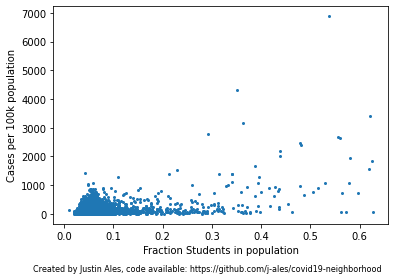

In [93]:

merged = merged.sort_values('latest_7_days', ascending=False)

targetWeek = 'latest_7_days'
tmp = merged

# plt.scatter(tmp['Student Percentage'],tmp[targetWeek],s=4)
plt.scatter(tmp['Student Percentage'], 1e5 * tmp[targetWeek].div(tmp['Total Pop'], axis=0), s=4)
plt.ylabel('Cases per 100k population')
plt.xlabel('Fraction Students in population')
plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -40), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)
plt.show()

In [ ]:

merged = merged.sort_values('latest_7_days', ascending=False)

#targetWeek = 'Student Percentage'
targetWeek = 'latest_7_days'
#targetX    ='Density (number of persons per hectare)'
targetX    ='56302 : Public houses and bars'
tmp = merged

plt.scatter(tmp[targetX], 1e5 * tmp[targetWeek].div(tmp['Total Pop'], axis=0), s=4)
#plt.scatter(1e5 * tmp[targetX].div(tmp['Total Pop'], axis=0), 1e5 * tmp[targetWeek].div(tmp['Total Pop'], axis=0), s=4)
#plt.scatter(tmp[targetX], tmp[targetWeek], s=4)

#plt.ylabel(targetWeek)
#plt.ylabel(targetWeek)
plt.xlabel('Number Pub Employees')
plt.ylabel('Cases per 100k pop.')

plt.annotate('Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood',
             (0,0), (-20, -40), xycoords='axes fraction',
             textcoords='offset points', va='top',
             fontsize=8)
plt.xlim(-10,500)
plt.show()

In [94]:
from IPython.display import display, HTML, Markdown



top30 = merged.head(30).copy()

top30['Student Percentage']=top30['Student Percentage'].mul(100)

# top30 = top30[
#     ['LA name (2020 boundaries)', 'msoa11_hclnm', 'latest_7_days', 'latest_7_days_per_100k', 'uni_distance', 'Student Population',
#      'Student Percentage', 'uni_name']]
top30 = top30[
     ['LA name (2020 boundaries)', 'msoa11_hclnm', 'latest_7_days', 'latest_7_days_per_100k','Student Percentage', 'uni_name',
      'uni_distance']]

di = {'msoa11_hclnm': 'Neighbourhood',
      'LA name (2020 boundaries)': 'Local Authority',
      'latest_7_days': 'Number of Cases',      
      'latest_7_days_per_100k': 'Cases per 100k pop',
      'uni_distance': 'Miles to Univeristy',
      'uni_name': 'Nearest University'
     }

top30.rename(di,axis=1,inplace=True)

pandas.set_option('precision',2)

fileModString = datetime.datetime.fromtimestamp(covidFileTimeStamp).strftime('%B - %d')
display(Markdown('Data for last 7 days up ' + fileModString))
display(HTML(top30.to_html(formatters={'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False)))
display(Markdown('<sup>Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood</sup>'))

Local Authority,Neighbourhood,Number of Cases,Cases per 100k pop,Student Percentage,Nearest University,Miles to Univeristy
Nottingham,"University Park, Lenton Abbey & Jubilee Campus",758,"6,879",54%,"UNIVERSITY OF NOTTINGHAM, THE",0.73
Sheffield,Endcliffe & Ranmoor,434,"4,301",35%,UNIVERSITY OF SHEFFIELD,1.53
Nottingham,"Arboretum, Forest & Trent University",410,"3,149",36%,NOTTINGHAM TRENT UNIVERSITY,0.43
Manchester,Fallowfield Central,407,"3,406",62%,THE UNIVERSITY OF MANCHESTER,1.85
Leeds,Hyde Park Corner & Woodhouse Cliff,372,"2,678",56%,UNIVERSITY OF LEEDS,0.76
Newcastle upon Tyne,City Centre & Arthur's Hill,333,"1,543",23%,NEWCASTLE UNIVERSITY,0.54
Exeter,Pennsylvania & University,322,"2,769",29%,UNIVERSITY OF EXETER,0.45
Leeds,University & Little Woodhouse,303,"2,642",56%,UNIVERSITY OF LEEDS,0.53
Liverpool,Central & Islington,294,"1,679",39%,UNIVERSITY OF LIVERPOOL,0.06
Newcastle upon Tyne,Shieldfield & Heaton Park,287,"1,403",31%,NORTHUMBRIA UNIVERSITY NEWCASTLE,0.40


<sup>Created by Justin Ales, code available: https://github.com/j-ales/covid19-neighborhood</sup>